## PROJECT 31: Web Traffic Time Series Forecasting

> ### TASK: Stady naïve forecasting method 


### Project goals and objectives

#### Project goal

- Studying **Mean method**
- Studying **Naïve method**
- Studying **Seasonal naïve method**
- Studying **Drift method**

#### Project objectives

1. Explore and prepare data 
2. Building different simple models 

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('dark')
import re
import math as math

import tensorflow as tf

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### LOAD DATA 

In [2]:
# Path to data

data_path_train = "data/train_1.csv.zip"

data_path_key = "data/key_1.csv.zip"

data_path_sample_sub = "data/sample_submission_1.csv.zip"

In [3]:
# Load the data
train_df = pd.read_csv(data_path_train, compression="zip")

keys_df = pd.read_csv(data_path_key, compression="zip")

sample_sub_df = pd.read_csv(data_path_sample_sub, compression="zip")

In [4]:
# Check result 
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
keys_df.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [6]:
sample_sub_df.head()

,Id,Visits
0,bf4edcf969af,0
1,929ed2bf52b9,0
2,ff29d0f51d5c,0
3,e98873359be6,0
4,fa012434263a,0


### DATA TRANSFORMATION

#### Missing values

In [7]:
# Check the data
print("Check the number of records")
print("Number of records: ", train_df.shape[0], "\n")

print("Null analysis")
empty_sample = train_df[train_df.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")

Check the number of records
Number of records:  145063 

Null analysis
Number of records contain 1+ null:  27786 



In [8]:
# Replacing nan values with forward fill
train_df = train_df.fillna(method='ffill', downcast='infer')
train_df.tail(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10
145062,Francisco_el_matemático_(serie_de_televisión_d...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10


#### Converting data to integer values to reduce memory consumption

In [9]:
for cols in train_df.columns[1:]:
    train_df[cols] = pd.to_numeric(train_df[cols], downcast='integer')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: int32(550), object(1)
memory usage: 305.5+ MB


#### Transposing the dataframe with time stamps in index, and page names in columns

In [11]:
df = pd.DataFrame(train_df.iloc[:,1:].values.T,
                  columns=train_df.Page.values, index=train_df.columns[1:])

df.index = pd.to_datetime(df.index, errors='ignore',
                                            dayfirst=False,
                                            yearfirst=False,
                                            utc=None,
                                            format="%Y/%m/%d",
                                            exact=False,
                                            # unit='D',
                                            infer_datetime_format=True,
                                            origin='unix',
                                            cache=True, 
                                            )
df.head(3)

,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01,18,11,1,35,35,12,12,118,5,6,...,3,3,3,3,3,3,3,3,3,3
2015-07-02,11,14,0,13,13,7,7,26,23,3,...,10,10,10,10,10,10,10,10,10,10
2015-07-03,5,15,1,10,10,4,4,30,14,5,...,0,0,0,0,0,0,0,0,0,0


#### List of different types of webpages

In [12]:
# First 10 pages
list(df.columns)[:10]

['2NE1_zh.wikipedia.org_all-access_spider',
 '2PM_zh.wikipedia.org_all-access_spider',
 '3C_zh.wikipedia.org_all-access_spider',
 '4minute_zh.wikipedia.org_all-access_spider',
 '52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider',
 '5566_zh.wikipedia.org_all-access_spider',
 '91Days_zh.wikipedia.org_all-access_spider',
 "A'N'D_zh.wikipedia.org_all-access_spider",
 'AKB48_zh.wikipedia.org_all-access_spider',
 'ASCII_zh.wikipedia.org_all-access_spider']

#### Creating Separate Dataframe for Wikipedia hits

In [13]:
wikipedia = (df.filter(like='wikipedia'))
wikipedia

,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01,18,11,1,35,35,12,12,118,5,6,...,3,3,3,3,3,3,3,3,3,3
2015-07-02,11,14,0,13,13,7,7,26,23,3,...,10,10,10,10,10,10,10,10,10,10
2015-07-03,5,15,1,10,10,4,4,30,14,5,...,0,0,0,0,0,0,0,0,0,0
2015-07-04,13,18,1,94,94,5,5,24,12,12,...,2,2,2,2,2,2,2,2,2,2
2015-07-05,14,11,0,4,4,20,20,29,9,6,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,20,30,4,11,11,19,4,23,30,29,...,8,7,4,4,4,12,12,12,12,12
2016-12-28,22,52,6,17,27,23,15,32,36,35,...,21,13,2,2,2,13,13,13,13,13
2016-12-29,19,45,3,19,13,17,6,39,38,44,...,14,12,4,4,4,3,3,3,3,3
2016-12-30,18,26,4,10,36,17,8,32,31,26,...,24,31,4,4,4,5,5,5,5,5


#### Data visualization

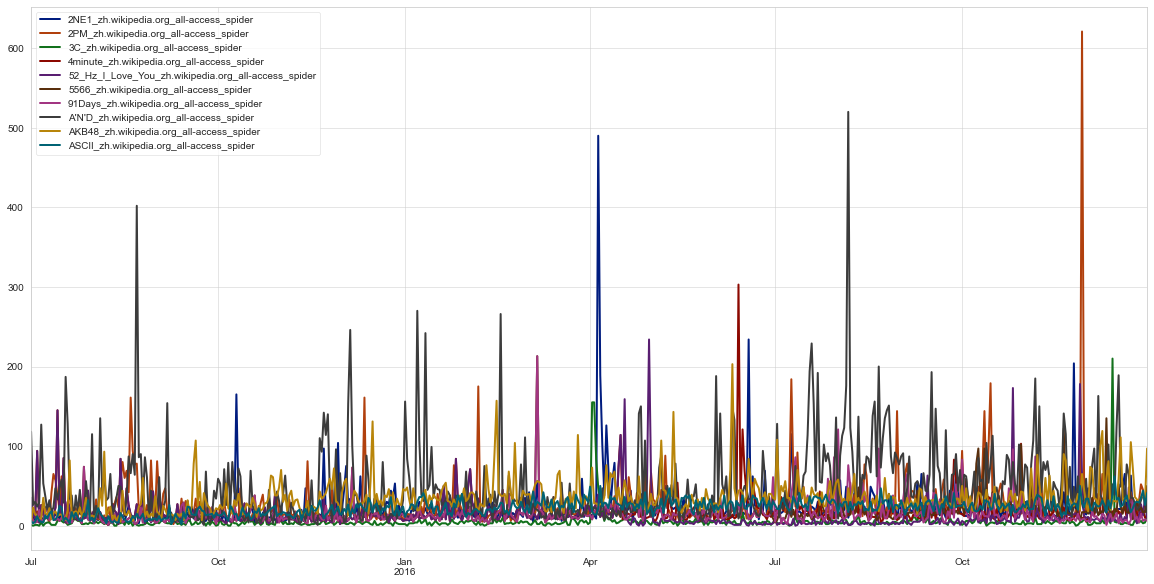

In [14]:
# Plotting 1st 10 page hits
wikipedia.iloc[:,0:10].plot(figsize=(20,10))
plt.show()

In [15]:
# Languages of wikipedia pages
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'other'

(wikipedia.columns.map(get_language)).unique()

Index(['zh', 'fr', 'en', 'other', 'ru', 'de', 'ja', 'es'], dtype='object')

In [16]:
len((wikipedia.columns.map(get_language)).unique())

8

In [17]:
languages = list((wikipedia.columns.map(get_language)).unique())
languages.remove('other')
languages

['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']

#### Creating Separate Dataframes for every language of wikipedia pages

In [18]:
for lang in (languages):
    locals()['lang_'+str(lang)] = wikipedia.loc[:, wikipedia.columns.str.contains('_'+str(lang)+'.wiki')]

In [19]:
lang_en.head(3)

,!vote_en.wikipedia.org_desktop_all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_desktop_all-agents","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_desktop_all-agents","""Weird_Al""_Yankovic_en.wikipedia.org_desktop_all-agents",100_metres_en.wikipedia.org_desktop_all-agents,10_Cloverfield_Lane_en.wikipedia.org_desktop_all-agents,10_Gigabit_Ethernet_en.wikipedia.org_desktop_all-agents,13_Hours:_The_Secret_Soldiers_of_Benghazi_en.wikipedia.org_desktop_all-agents,1551_en.wikipedia.org_desktop_all-agents,1896_Summer_Olympics_en.wikipedia.org_desktop_all-agents,...,Zgornji_Lehen_na_Pohorju_en.wikipedia.org_all-access_all-agents,Zhao_Lin_en.wikipedia.org_all-access_all-agents,Zhejiang_Yueju_Troupe_en.wikipedia.org_all-access_all-agents,Zheleznogorsk_Airport_en.wikipedia.org_all-access_all-agents,Zhu_Qingyuan_en.wikipedia.org_all-access_all-agents,Zikanyrops_sparsa_en.wikipedia.org_all-access_all-agents,Zillur_Rahman_John_en.wikipedia.org_all-access_all-agents,Zitadelle_en.wikipedia.org_all-access_all-agents,"Zovashen_(Dzhannatlu),_Ararat_en.wikipedia.org_all-access_all-agents",Zurich.minds_en.wikipedia.org_all-access_all-agents
2015-07-01,3,3,3,2403,982,982,1078,1078,11,366,...,1,3,3,3,3,1,7,10,10,8
2015-07-02,4,4,4,20136,881,881,1116,45,9,392,...,1,1,1,5,1,5,9,6,6,5
2015-07-03,7,7,7,1850,794,794,869,462,19,322,...,1,2,1,4,2,2,3,4,1,7


In [20]:
for lang in (languages):
    locals()['hits_'+str(lang)] = np.array(locals()['lang_'+str(lang)].iloc[:,:].sum(axis=1))

In [21]:
for lang in (languages):
    print((locals()['hits_'+str(lang)]).shape)

(550,)
(550,)
(550,)
(550,)
(550,)
(550,)
(550,)


In [22]:
keys = languages
values = ['Chinese', 'French', 'English', 'Russian', 'German', 'Japanese', 'Spanish']

In [23]:
d = dict(zip(keys,values))

In [24]:
index = wikipedia.index

hits = pd.DataFrame(index=index, columns=list(d.values()))
hits = hits.fillna(0)

In [25]:
for key, value in d.items():
    hits[value] = locals()['hits_'+str(key)]

In [26]:
hits

,Chinese,French,English,Russian,German,Japanese,Spanish
2015-07-01,5456207,31228817,120391534,9801685,15081056,12029356,16103942
2015-07-02,4269619,8861578,119093656,9740966,14775940,13803809,15424574
2015-07-03,4427445,8511084,113155589,9005289,14216769,12371482,13831014
2015-07-04,4268193,9441573,117289794,8498550,12797849,15725650,12986072
2015-07-05,4559700,8958291,122355756,9658335,14941068,15235858,14225614
...,...,...,...,...,...,...,...
2016-12-27,6520782,15306059,146302021,15073578,21196967,16745293,16491574
2016-12-28,6575150,13822342,142185728,14034697,20203002,16795504,17200073
2016-12-29,6103644,13420548,151236461,13514914,19378955,18305166,16168558
2016-12-30,6204629,12496021,125827146,12098492,18494742,19578058,11774502


In [27]:
hits.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Chinese   550 non-null    int64
 1   French    550 non-null    int64
 2   English   550 non-null    int64
 3   Russian   550 non-null    int64
 4   German    550 non-null    int64
 5   Japanese  550 non-null    int64
 6   Spanish   550 non-null    int64
dtypes: int64(7)
memory usage: 34.4 KB


In [28]:
hits = hits.asfreq('D')

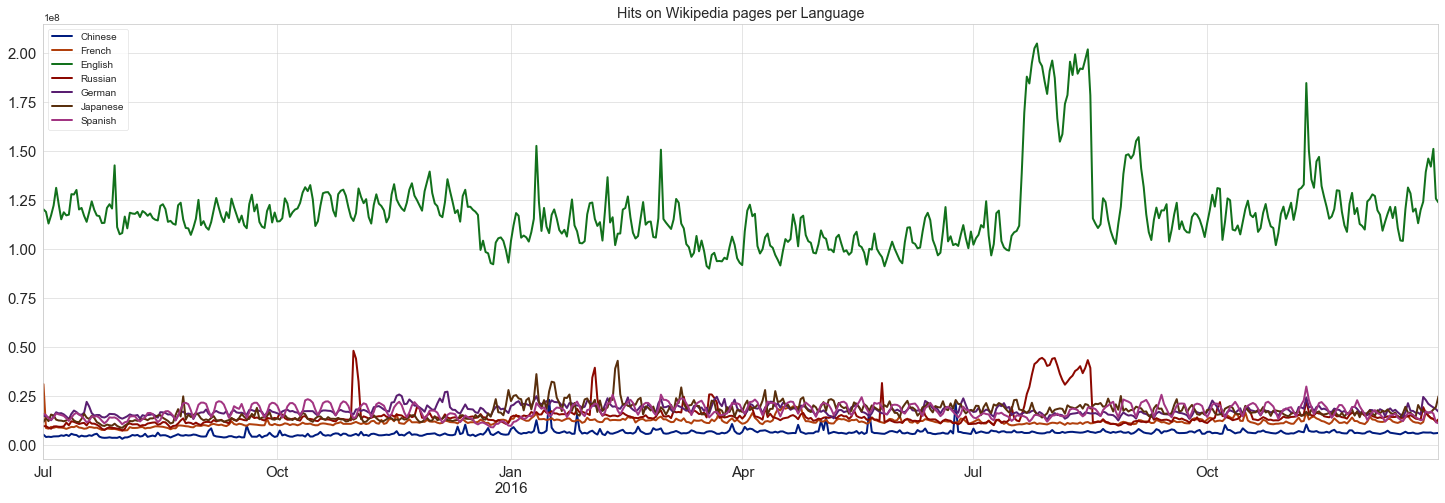

In [29]:
hits.plot(figsize=(25,8), title ='Hits on Wikipedia pages per Language', fontsize=15)
plt.legend(loc='upper left')
plt.show()

#### Split data

In [30]:
brk = 0.8
data_split = int(len(hits)*brk)
data_split

440

In [31]:
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

len(X), len(y)

(440, 110)

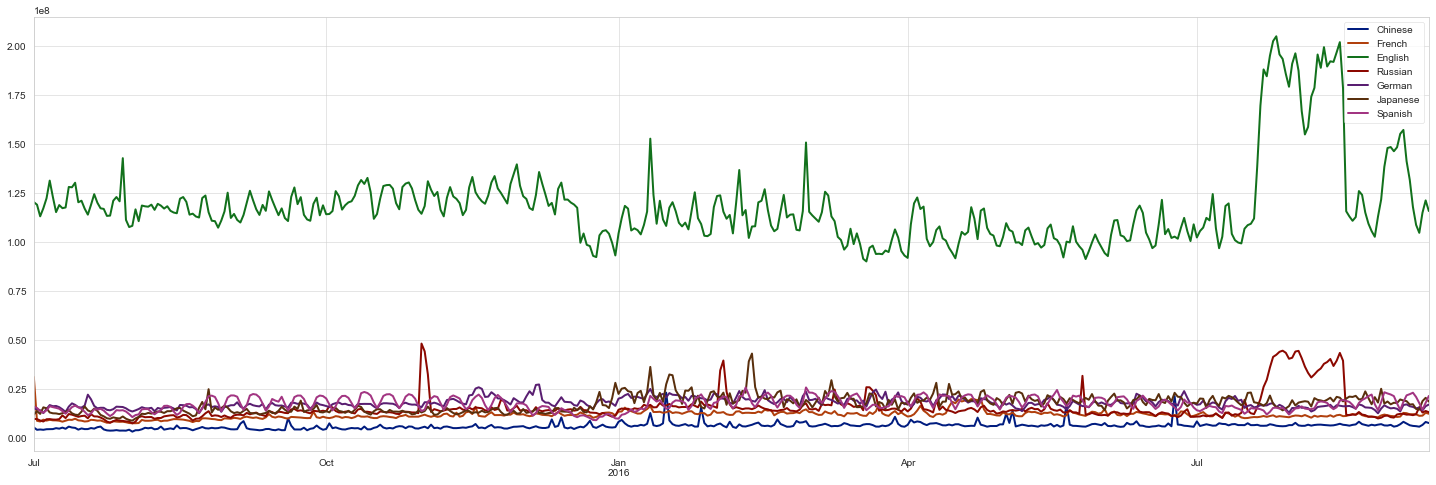

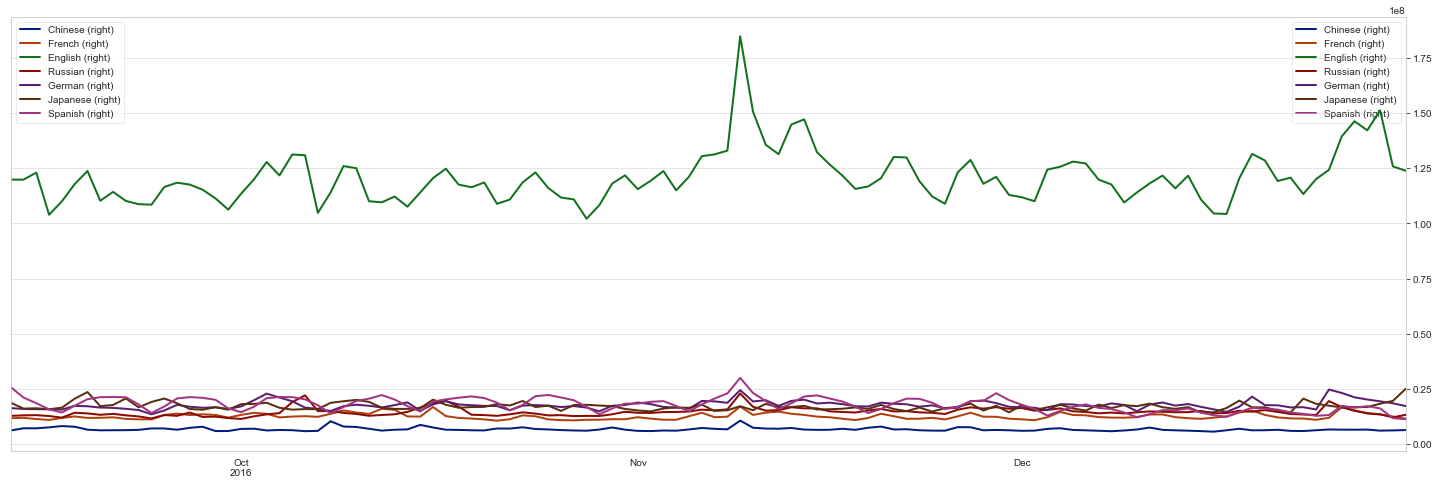

In [32]:
X.plot(figsize=(25,8))
y.plot(figsize=(25,8), secondary_y=True)
plt.legend(loc='upper left')
plt.show()

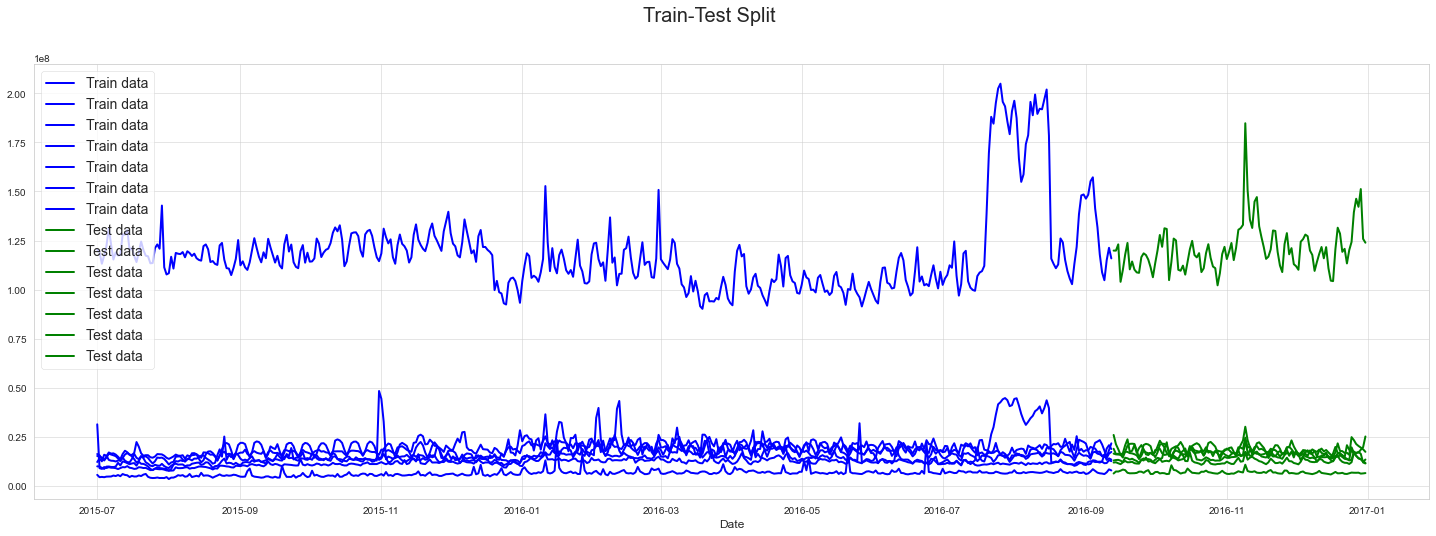

In [33]:
plt.figure(figsize=(25,8))
plt.suptitle('Train-Test Split', fontsize=20)
plt.plot(X, label="Train data", color='blue')
plt.plot(y, label="Test data", color='green')
plt.xlabel("Date")
plt.legend(fontsize=14, loc='upper left')
plt.show();

In [34]:
print(X.shape)
print(y.shape)
print('Number of features = '+str(X.shape[1]))
print('Number of train instances = '+str(X.shape[0]))
print('Number of test instances = '+str(y.shape[0]))

(440, 7)
(110, 7)
Number of features = 7
Number of train instances = 440
Number of test instances = 110


#### Evaluation metrics 

In [35]:
def evaluate_preds(y_true, y_pred):
    mae = MeanAbsoluteError()
    mse = MeanSquaredError()
    rmse = MeanSquaredError(square_root=True)
    mape = MeanAbsolutePercentageError(symmetric=False)
    mase = MeanAbsoluteScaledError()
    mase = MeanAbsoluteScaledError()
    
    
    return{"mae": mae(y_true, y_pred),
           "mse": mse(y_true, y_pred),
           "rmse": mape(y_true, y_pred),
           "mape": mape(y_true, y_pred),
           "mase": mase(y_true, y_pred, y_train=y)}

### MEAN METHOD

In [36]:
fh = ForecastingHorizon(y.index, is_relative=False)
fh

ForecastingHorizon(['2016-09-13', '2016-09-14', '2016-09-15', '2016-09-16',
               '2016-09-17', '2016-09-18', '2016-09-19', '2016-09-20',
               '2016-09-21', '2016-09-22',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=110, freq='D', is_relative=False)

In [37]:
mean_method = NaiveForecaster(strategy="mean", window_length=14)
mean_method.fit(X)

NaiveForecaster(strategy='mean', window_length=14)

In [38]:
y_pred = mean_method.predict(fh=fh)
y_pred.round(1)

,Chinese,French,English,Russian,German,Japanese,Spanish
2016-09-13,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-09-14,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-09-15,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-09-16,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-09-17,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
...,...,...,...,...,...,...,...
2016-12-27,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-12-28,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-12-29,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8
2016-12-30,6842853.0,11890912.6,132878229.8,12407287.1,15707499.9,17988489.2,19826939.8


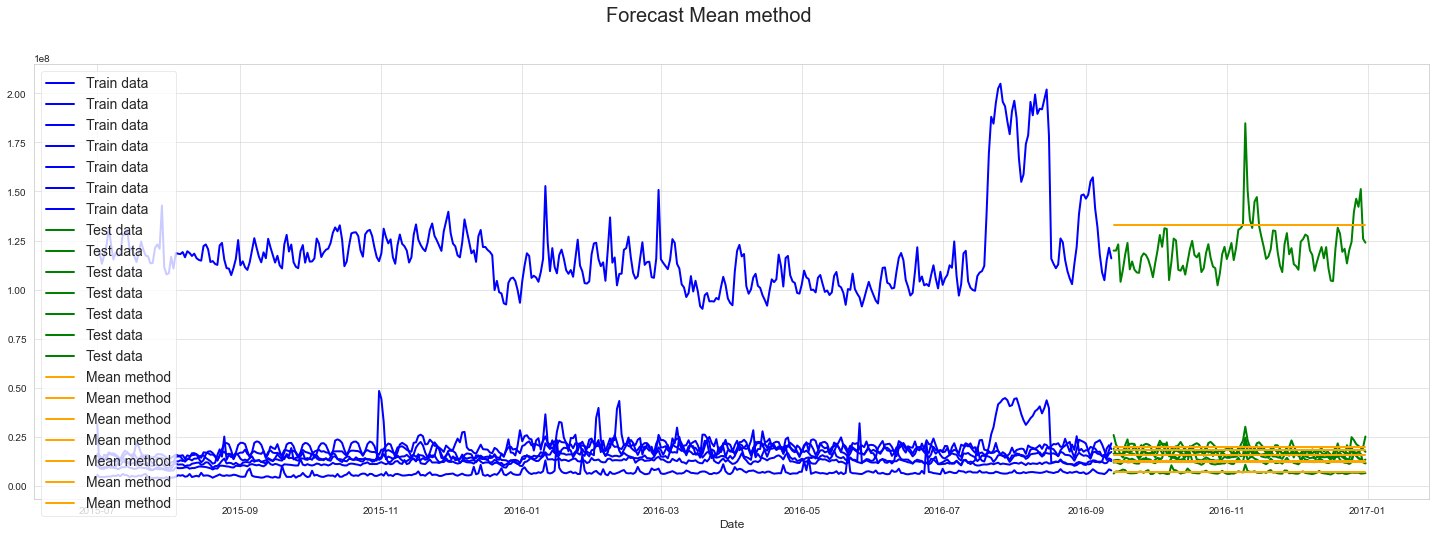

In [39]:
plt.figure(figsize=(25,8))
plt.suptitle('Forecast Mean method', fontsize=20)
plt.plot(X, label="Train data", color='blue')
plt.plot(y, label="Test data", color='green')
plt.plot(y_pred, label="Mean method", color='orange')
plt.xlabel("Date")
plt.legend(fontsize=14, loc='upper left')
plt.show();

In [40]:
mean_method_results = evaluate_preds(y_true=y,
                               y_pred=y_pred)
mean_method_results

{'mae': 3629581.9729128047,
 'mse': 45801531594934.69,
 'rmse': 0.1192573070352343,
 'mape': 0.1192573070352343,
 'mase': 1.7654481825047628}

### NAÏVE METHOD

In [41]:
naïve_method = NaiveForecaster(strategy="last")
naïve_method.fit(X)

NaiveForecaster()

In [42]:
y_pred = naïve_method.predict(fh=fh)
y_pred.round(1)

,Chinese,French,English,Russian,German,Japanese,Spanish
2016-09-13,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-09-14,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-09-15,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-09-16,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-09-17,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
...,...,...,...,...,...,...,...
2016-12-27,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-12-28,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-12-29,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0
2016-12-30,7727734.0,12455964.0,115873518.0,13238839.0,17155854.0,18642177.0,21527161.0


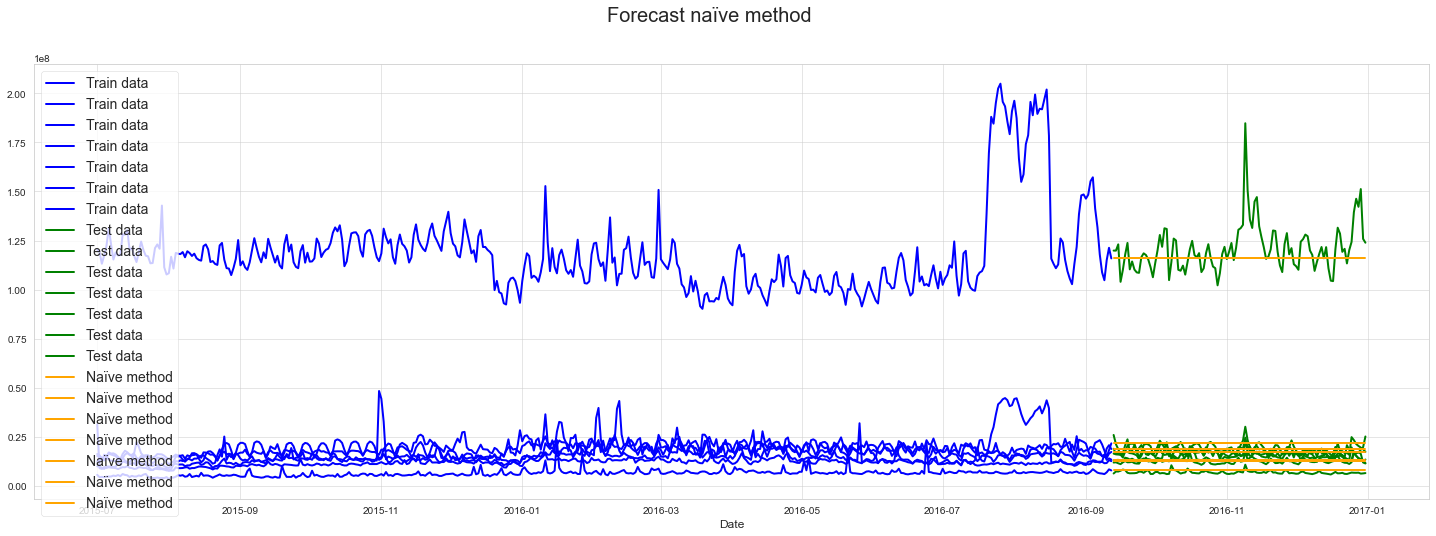

In [43]:
plt.figure(figsize=(25,8))
plt.suptitle('Forecast naïve method', fontsize=20)
plt.plot(X, label="Train data", color='blue')
plt.plot(y, label="Test data", color='green')
plt.plot(y_pred, label="Naïve method", color='orange')
plt.xlabel("Date")
plt.legend(fontsize=14, loc='upper left')
plt.show();

In [44]:
naïve_method_results = evaluate_preds(y_true=y,
                               y_pred=y_pred)
naïve_method_results

{'mae': 2834937.125974026,
 'mse': 29075564446539.125,
 'rmse': 0.12552319033083278,
 'mape': 0.12552319033083278,
 'mase': 1.3789286573267747}

### SEASONAL NAÏVE METHOD

In [45]:
seasonal_naïve_method = NaiveForecaster(strategy="last", sp=7)
seasonal_naïve_method.fit(X)

NaiveForecaster(sp=7)

In [46]:
y_pred = seasonal_naïve_method.predict(fh=fh)
y_pred.round(1)

,Chinese,French,English,Russian,German,Japanese,Spanish
2016-09-13,6589874.0,12160307.0,131776316.0,12058595.0,16293868.0,17143960.0,22447144.0
2016-09-14,6254952.0,12212785.0,117915197.0,11736752.0,15946883.0,17312076.0,23185799.0
2016-09-15,6120211.0,12152809.0,108773619.0,12264092.0,15196216.0,14923591.0,21000053.0
2016-09-16,5859838.0,11392616.0,104739055.0,15804933.0,15602285.0,14554949.0,17886463.0
2016-09-17,6755467.0,11492486.0,114964945.0,13083499.0,14183725.0,18897187.0,14548802.0
...,...,...,...,...,...,...,...
2016-12-27,6589874.0,12160307.0,131776316.0,12058595.0,16293868.0,17143960.0,22447144.0
2016-12-28,6254952.0,12212785.0,117915197.0,11736752.0,15946883.0,17312076.0,23185799.0
2016-12-29,6120211.0,12152809.0,108773619.0,12264092.0,15196216.0,14923591.0,21000053.0
2016-12-30,5859838.0,11392616.0,104739055.0,15804933.0,15602285.0,14554949.0,17886463.0


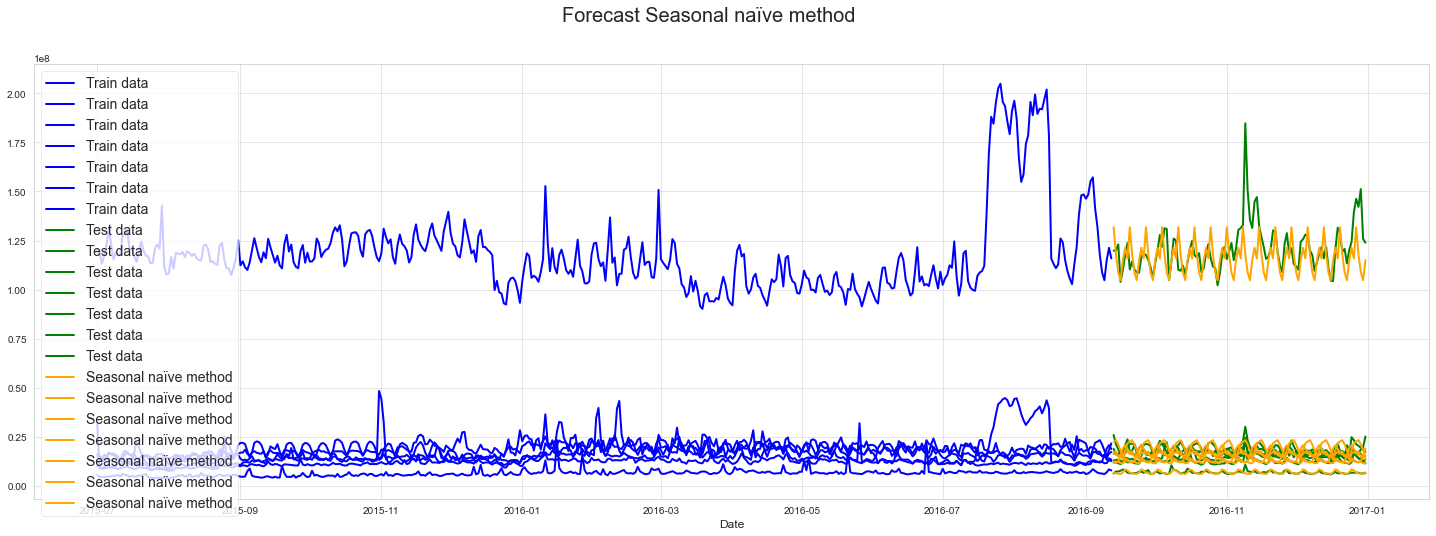

In [47]:
plt.figure(figsize=(25,8))
plt.suptitle('Forecast Seasonal naïve method', fontsize=20)
plt.plot(X, label="Train data", color='blue')
plt.plot(y, label="Test data", color='green')
plt.plot(y_pred, label="Seasonal naïve method", color='orange')
plt.xlabel("Date")
plt.legend(fontsize=14, loc='upper left')
plt.show();

In [48]:
seasonal_naïve_method_results = evaluate_preds(y_true=y,
                               y_pred=y_pred)
seasonal_naïve_method_results

{'mae': 2669367.6,
 'mse': 29743048301304.23,
 'rmse': 0.10221792271534058,
 'mape': 0.10221792271534058,
 'mase': 1.2983947498711899}

### DRIFT METHOD

In [49]:
drift_method = NaiveForecaster(strategy="drift")
drift_method.fit(X)

NaiveForecaster(strategy='drift')

In [50]:
y_pred = drift_method.predict(fh=fh)
y_pred.round(1)

,Chinese,French,English,Russian,German,Japanese,Spanish
2016-09-13,7732908.3,12413201.2,115863226.4,13246668.5,17160580.2,18657240.4,21539514.6
2016-09-14,7738082.6,12370438.5,115852934.8,13254498.0,17165306.4,18672303.7,21551868.1
2016-09-15,7743257.0,12327675.7,115842643.2,13262327.5,17170032.6,18687367.1,21564221.7
2016-09-16,7748431.3,12284912.9,115832351.6,13270157.0,17174758.8,18702430.5,21576575.3
2016-09-17,7753605.6,12242150.2,115822060.0,13277986.5,17179485.0,18717493.9,21588928.9
...,...,...,...,...,...,...,...
2016-12-27,8276212.0,7923111.1,114782607.5,14068766.8,17656830.3,20238894.6,22836639.8
2016-12-28,8281386.4,7880348.3,114772315.9,14076596.4,17661556.5,20253958.0,22848993.4
2016-12-29,8286560.7,7837585.6,114762024.3,14084425.9,17666282.7,20269021.3,22861347.0
2016-12-30,8291735.0,7794822.8,114751732.7,14092255.4,17671008.9,20284084.7,22873700.6


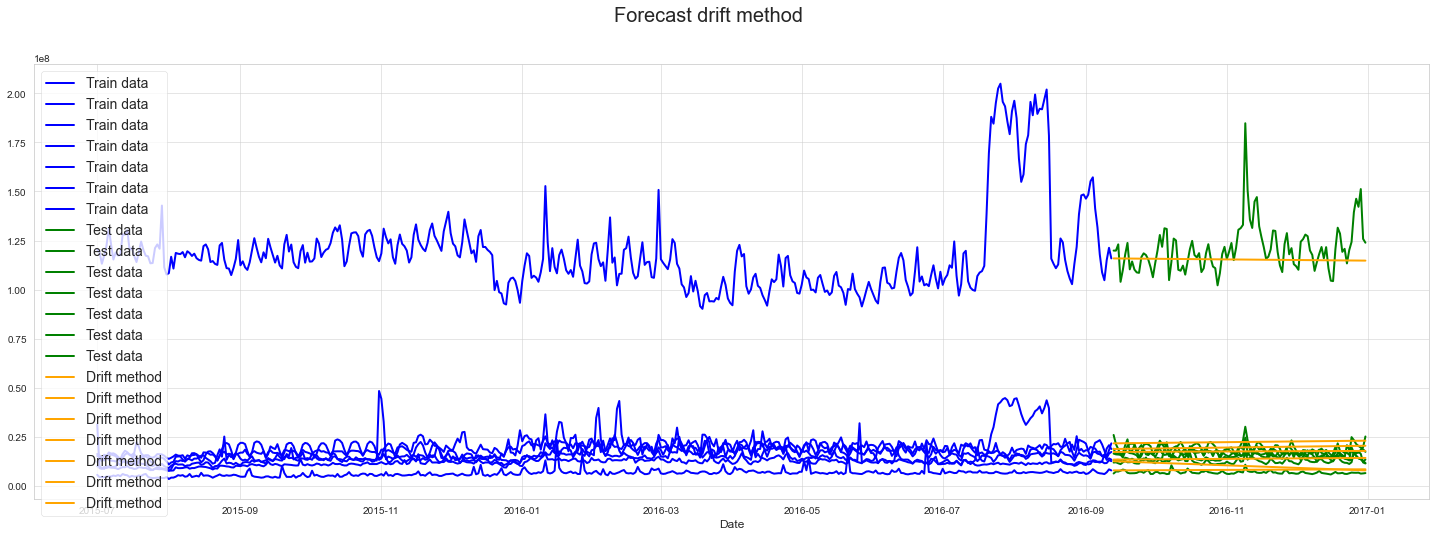

In [51]:
plt.figure(figsize=(25,8))
plt.suptitle('Forecast drift method', fontsize=20)
plt.plot(X, label="Train data", color='blue')
plt.plot(y, label="Test data", color='green')
plt.plot(y_pred, label="Drift method", color='orange')
plt.xlabel("Date")
plt.legend(fontsize=14, loc='upper left')
plt.show();

In [52]:
drift_method_results = evaluate_preds(y_true=y,
                               y_pred=y_pred)
drift_method_results

{'mae': 3272218.5597520927,
 'mse': 32821610169863.977,
 'rmse': 0.15756321577682958,
 'mape': 0.15756321577682958,
 'mase': 1.5916246973302528}